## Imports

In [2]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer 
import torch
import pandas as pd
from datasets import Dataset
import seaborn as sns       

comet_ml is installed but `COMET_API_KEY` is not set.


In [3]:
print(torch.cuda.is_available())
print(torch.version.cuda)

True
12.1


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", return_tensor="pt")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy = evaluate.load("accuracy")

id2label = {0: "CONTROL", 1: "BROCA"}
label2id = {"CONTROL": 0, "BROCA": 0}

model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
# dataset_filename = "input.csv"
dataset_filename = "../../preprocessing/input.csv"
data = pd.read_csv(dataset_filename, encoding='utf8', index_col=False).drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [12]:
data

,scenario,source_file,original_text,preprocessed_text,label
0,Cinderella_Intro,UMD21.cha,and &-uh (.) <is &-um> [/] is to have a &-um b...,"and is to have a ball , maybe coming out party.",0
1,Cinderella,fridriksson10a.cha,&-uh horse [/] horse &=hands:wheel castle &=ge...,horse horse castle princess.,1
2,Cinderella,capilouto65a.cha,and off to [/] &+s to see the princess [: prin...,and off to to see the princess she went.,0
3,Cinderella,capilouto06a.cha,but &-uh she waited on everybody . 734148_736...,but she waited on everybody.,0
4,Important_Event,43-2.cha,"and <I was like> [//] they were like +""/. 899...",and they were like.,0
...,...,...,...,...,...
56165,Important_Event,UNH1022.cha,&-like (be)cause they also knew each other too...,because they also knew each other too.,0
56166,Umbrella,wright24a.cha,"+"" I'm fine . 287426_288046",i'm fine.,0
56167,Sandwich_Picture,50-2.cha,I don't know . [+ exc] 1545318_1545848,i don't know.,1
56168,Flood,kempler04a.cha,<and she [: he] [* s:r:gc:pro-ret] said> [//] ...,and he said.,1


In [6]:
data["label"].value_counts()

label
0    41075
1    15095
Name: count, dtype: int64

In [7]:
dataset = Dataset.from_pandas(data)

In [8]:
dataset

Dataset({
    features: ['scenario', 'source_file', 'original_text', 'preprocessed_text', 'label'],
    num_rows: 56170
})

In [9]:
def compute_metrics(eval_pred):
    metrics = ["accuracy", "recall", "precision", "f1"] #List of metrics to return
    metric={}
    for met in metrics:
       metric[met] = evaluate.load(met)
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metric_res={}
    for met in metrics:
       metric_res[met]=metric[met].compute(predictions=predictions, references=labels)[met]
    print(metric_res)
    return metric_res

In [10]:
def preprocess_function(examples):
    return tokenizer(examples["preprocessed_text"], padding=True, truncation=True, return_tensors="pt")

In [11]:
tokenized_data = dataset.map(preprocess_function, batched=True).with_format("torch")

Map:   0%|          | 0/56170 [00:00<?, ? examples/s]

In [13]:
tokenized_data_split = tokenized_data.train_test_split(test_size=0.2, seed=42)

In [21]:
tokenized_data_split['test']['label']

tensor([0, 1, 1,  ..., 0, 0, 0])

In [24]:
training_args = TrainingArguments(
    output_dir="../models/bert_classifier",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
    use_cpu = False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_split["train"],
    eval_dataset=tokenized_data_split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# trainer.train()
# trainer.save_model('../models/bert_finetuned')

C:\Users\imruh\miniconda3\envs\thesis\lib\site-packages\accelerate\accelerator.py:437: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


{'accuracy': 0.9150792237849386, 'recall': 0.7791124457791124, 'precision': 0.8888465930719451, 'f1': 0.8303698435277381}
{'accuracy': 0.9211322770162008, 'recall': 0.8351685018351686, 'precision': 0.8645941278065631, 'f1': 0.8496266123557367}


In [25]:
# trainer.evaluate()

{'accuracy': 0.9150792237849386, 'recall': 0.7791124457791124, 'precision': 0.8888465930719451, 'f1': 0.8303698435277381}


{'eval_loss': 0.22286322712898254,
 'eval_accuracy': 0.9150792237849386,
 'eval_recall': 0.7791124457791124,
 'eval_precision': 0.8888465930719451,
 'eval_f1': 0.8303698435277381,
 'eval_runtime': 19.6993,
 'eval_samples_per_second': 570.275,
 'eval_steps_per_second': 35.687,
 'epoch': 2.0}

# Evaluate model

In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModelForSequenceClassification.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [19]:
sentences = tokenized_data_split["test"]["preprocessed_text"]
true_labels = tokenized_data_split["test"]["label"] 

In [20]:
pred_labels = []

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device) 
    
    with torch.no_grad():
        logits = model(inputs).logits
    predicted_class_id = logits.argmax().item()
    pred_labels.append(predicted_class_id)

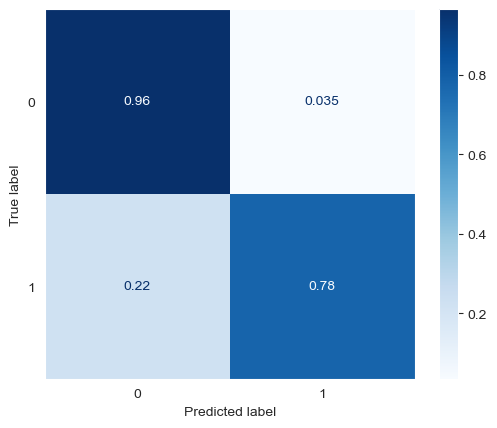

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, pred_labels, normalize='true')
tn, fp, fn, tp = cm.ravel()
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, normalize="true", cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [22]:
accuracy_score(true_labels, pred_labels)

0.9150792237849386

In [23]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * precision * recall)/ (precision+recall)
print(precision) 
print(recall)
print(f1)

0.9564799376821336
0.7791124457791124
0.8587332264042744


# Example evaluate on synthetic data

In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModelForSequenceClassification.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

# Sentences from possible linguistic aug of "so he is walking to school"
sentences = ["so walking to school", "so is school", "so is to school", "so is walking school", "so is walking to school", "so he to school", "so he walking school", "so he walking to school", "so he is school", "so he is to school", "so he is walking school", "so he is walking to school"]

label = [1] * len(sentences)
pred = []
for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors="pt").input_ids.to(device)

    with torch.no_grad():
        logits = model(inputs).logits
        predicted_class_id = logits.argmax().item()
        pred.append(predicted_class_id)
        print(sentence, id2label[predicted_class_id])

print(accuracy.compute(predictions=pred, references=label))

so walking to school BROCA
so is school BROCA
so is to school BROCA
so is walking school BROCA
so is walking to school CONTROL
so he to school BROCA
so he walking school BROCA
so he walking to school BROCA
so he is school CONTROL
so he is to school CONTROL
so he is walking school CONTROL
so he is walking to school CONTROL
{'accuracy': 0.5833333333333334}


# Feature visualization

In [33]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)

In [34]:
def extract_hidden_states(batch):
    sentences = [x for x in batch["preprocessed_text"]]
    with torch.no_grad():
        inputs = tokenizer(sentences, return_tensors="pt", padding=True, truncation=True).input_ids.to(device)
        last_hidden_state = model(inputs).last_hidden_state

    return {"hidden state": last_hidden_state[:, 0].cpu().numpy()}

In [35]:
hidden = tokenized_data_split.map(
    extract_hidden_states, batched=True)

Map:   0%|          | 0/44936 [00:00<?, ? examples/s]

Map:   0%|          | 0/11234 [00:00<?, ? examples/s]

In [36]:
hidden.save_to_disk('../models/bert_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/44936 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11234 [00:00<?, ? examples/s]

In [37]:
hidden["test"].column_names

['scenario',
 'source_file',
 'original_text',
 'preprocessed_text',
 'label',
 'input_ids',
 'attention_mask',
 'hidden state']

In [38]:
print(np.array(hidden["train"]["hidden state"]).shape)

(44936, 768)


In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

X_train = np.array(hidden["train"]["hidden state"])
y_train = np.array(hidden["train"]["label"])

X_test = np.array(hidden["test"]["hidden state"])
y_test = np.array(hidden["test"]["label"])

In [40]:
# reduce to 2d for visualization
pca = PCA(n_components=2)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_2d = pca.fit_transform(x_scaled)
x_2d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_2d1 = pca.fit_transform(x_scaled1)
x_2d1.shape

(11234, 2)

In [41]:
# reduce to 3d for visualization
pca = PCA(n_components=3)

x_scaled = MinMaxScaler().fit_transform(X_train)
x_3d = pca.fit_transform(x_scaled)
x_3d.shape

x_scaled1 = MinMaxScaler().fit_transform(X_test)
x_3d1 = pca.fit_transform(x_scaled1)
x_3d1.shape

(11234, 3)

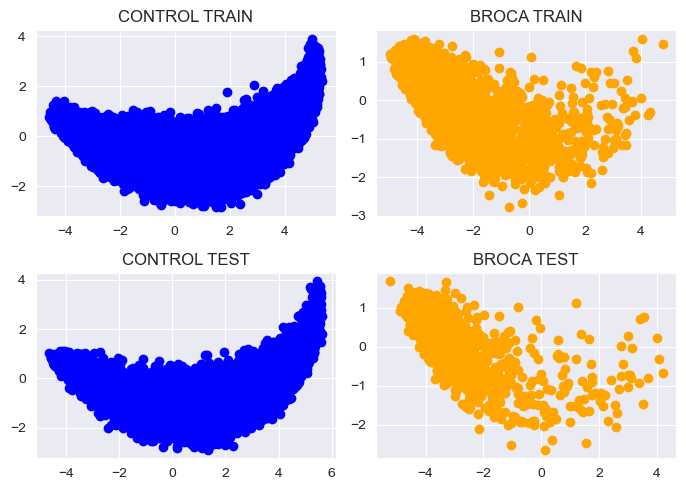

In [49]:
# 2d viz
fig, ax = plt.subplots(2, 2, figsize=(7, 5))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub = x_2d[y_train == i]
    ax[i].scatter(x_2d_sub[:, 0], x_2d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label] +" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_2d_sub1 = x_2d1[y_test == i]
    ax[i+2].scatter(x_2d_sub1[:, 0], x_2d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label] +" TEST" )

plt.tight_layout()
plt.show()

### Shows us that there might be an overlap in control text and broca text which indistinguishable to the model (so model goes with control as sort of default strategy)

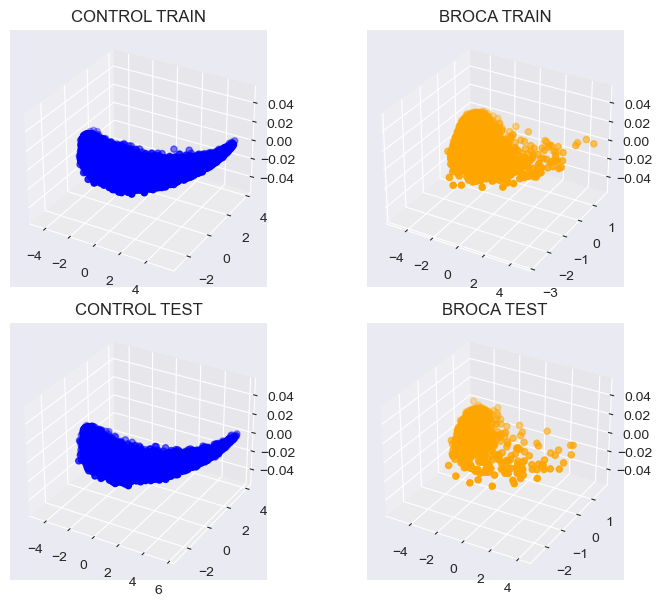

In [50]:
# 3d vis

fig, ax = plt.subplots(2, 2, subplot_kw={"projection": "3d"}, figsize=(8, 6))
ax = ax.flatten()
cmaps = ["blue", "orange"]
labels = set([x.item() for x in tokenized_data_split["train"]["label"]])

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub = x_3d[y_train == i]
    ax[i].scatter(x_3d_sub[:, 0], x_3d_sub[:, 1], color=cmap)
    ax[i].set_title(id2label[label]+" TRAIN")
    
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    x_3d_sub1 = x_3d1[y_test == i]
    ax[i+2].scatter(x_3d_sub1[:, 0], x_3d_sub1[:, 1], color=cmap)
    ax[i+2].set_title(id2label[label]+" TEST" )

plt.tight_layout()
plt.show()

# Attention viz

In [54]:
from bertviz import model_view, head_view
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

tokenizer = AutoTokenizer.from_pretrained("../models/bert_finetuned", return_tensor="pt")
model = AutoModel.from_pretrained("../models/bert_finetuned")
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [55]:
input = tokenizer.encode(sentences[0], return_tensors="pt")
output = model(input, output_attentions=True)

In [56]:
attention = output[-1]

In [57]:
tokens = tokenizer.convert_ids_to_tokens(input[0]) 

In [60]:
model_view(attention, tokens)

<IPython.core.display.Javascript object>

In [61]:
sentences[0]

'and you know one of those across the crowded room.'